In [37]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
bucket = 'ava-experimental' # custom bucket name.
# bucket = sess.default_bucket()
prefix = 'DEMO-4-ObjectDetection'
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

arn:aws:iam::467343721842:role/service-role/AmazonSageMaker-ExecutionRole-20200520T093118
811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest
CPU times: user 93.3 ms, sys: 11.8 ms, total: 105 ms
Wall time: 149 ms


In [38]:
%%bash
rm -rf train
rm -rf train_annotation
rm -rf test
rm -rf test_annotation
mkdir train
mkdir train_annotation
mkdir test
mkdir test_annotation
cp train_image_folder/* train

In [39]:
from os import listdir
import os
import json
import xml.etree.cElementTree as ET

mypath = "train_annot_folder"
jsonpath = "train_annotation"

files = listdir(mypath)

for f in files:
    
    fullfilename = mypath + '/' + f
    jsonfullfilename = jsonpath + '/' + f.replace("xml","json")
    line = {}
    
    tree = ET.ElementTree(file=fullfilename)
    root = tree.getroot()
    categories = {}
    for child in root:
    
        if child.tag == "filename":
            line["file"] = child.text
        if child.tag == "size":
            line["image_size"] = []
            image_size = {}
            for s in child:
                if s.tag == "width":
                    image_size["width"] = int(s.text)
                elif s.tag == "height":
                    image_size["height"] = int(s.text)
                elif s.tag == "depth":
                    image_size["depth"] = int(s.text)
                else:
                    print(s.tag,":",s.text)
        
            line["image_size"].append(image_size)
            line["annotations"] = []            
            line["categories"] = []
            
        if child.tag == "object":
            annotation = {}
            for s in child:
                                            
                if s.tag == "bndbox": 
                    left = 0
                    right = 0
                    top = 0
                    bottom = 0
                    for ss in s:
                        if ss.tag == "xmin":
                            left = int(ss.text)
                        elif ss.tag == "xmax":
                            right = int(ss.text)
                        elif ss.tag == "ymin":
                            top = int(ss.text)
                        elif ss.tag == "ymax":
                            bottom = int(ss.text)
                    annotation["left"] = left
                    annotation["top"] = top
                    annotation["width"] = right - left
                    annotation["height"] = bottom - top
                if s.tag == "name":
                    category = {}
                    if s.text == "person with helmet":
                        annotation["class_id"] = 0
                        category = {"class_id": 0, "name": s.text}
                    elif s.text == "person":
                        annotation["class_id"] = 1
                        category = {"class_id": 1, "name": s.text}
                    elif s.text == "person without helmet": 
                        annotation["class_id"] = 2
                        category = {"class_id": 2, "name": s.text}
                    elif s.text == "helmet": 
                        annotation["class_id"] = 3
                        category = {"class_id": 3, "name": s.text}
                    if not category in line["categories"]:
                        line["categories"].append(category)
            line["annotations"].append(annotation)
            
    if len(line["annotations"]) > 0 :
        with open(jsonfullfilename,"w") as p:
            json.dump(line,p)
    else:
        os.remove('train/' + f.replace("xml","jpg"))


In [40]:
import shutil
import os

json_files = os.listdir('train_annotation')

m = 4
i = 0
for f in json_files:
    i = i + 1
    if i%m == 0:
        shutil.move(jsonpath + '/' + f, 'test_annotation/')
        shutil.move('train/' + f.replace("json","jpg"), 'test/')

In [41]:
print ( "%d files in training folder." % len(os.listdir('train_annotation')))
print ( "%d files in test folder." % len(os.listdir('test_annotation')))

824 files in training folder.
411 files in test folder.


In [42]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='test', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='test_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 11.2 s, sys: 577 ms, total: 11.7 s
Wall time: 2min 54s


In [43]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [62]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [63]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=0,
                             num_classes=4,
                             mini_batch_size=16,
                             epochs=100,
                             learning_rate=0.0001,
                             lr_scheduler_step='',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=824)

In [64]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

In [52]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.xlarge')

Using already existing model: object-detection-2020-05-28-13-16-38-673


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:467343721842:endpoint/object-detection-2020-05-28-13-16-38-673".

In [53]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = ["green","yellow","red"]

        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)

            if cls_id == 0 or cls_id == 2:       
                xmin = int(x0 * width)
                ymin = int(y0 * height)
                xmax = int(x1 * width)
                ymax = int(y1 * height)
                rect = plt.Rectangle((xmin, ymin), 
                                     xmax - xmin,
                                     ymax - ymin, 
                                     fill=False,
                                     edgecolor=colors[cls_id],
                                     linewidth=1.0)
                plt.gca().add_patch(rect)
                class_name = str(cls_id)
                if classes and len(classes) > cls_id:
                    class_name = classes[cls_id]
                plt.gca().text(xmin, ymin - 2,
                                '{:s} {:.3f}'.format(class_name, score),
                                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                        fontsize=12, color='white')
        plt.show()

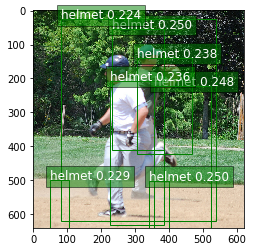

In [54]:
file_name = 'baseball.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
object_categories = ['helmet', 'person', 'no helmet', 'NA']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.22

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

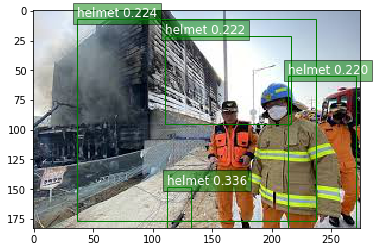

In [55]:
file_name = 'wi_and_wo_helmet.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
object_categories = ['helmet', 'person', 'no helmet', 'NA']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.22

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

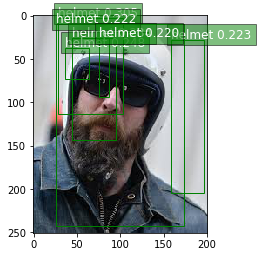

In [56]:
file_name = 'person_with_helmet.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
object_categories = ['helmet', 'person', 'no helmet', 'NA']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.22

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

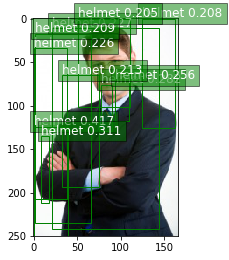

In [57]:
file_name = 'a_person_wo_helmet.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
object_categories = ['helmet', 'person', 'no helmet', 'NA']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)